In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.ao.nn.quantized.functional import threshold
from torch.utils.data import DataLoader

from models import Autoencoder, DEC
from utils import train_autoencoder, train_dec, load_mnist

from utils import knn_impute_image, mean_impute_image
from utils import Missingness

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.decomposition import PCA

from utils import load_mnist, load_fashion_mnist
from utils.training_ae import train_autoencoder
from utils.training_dec import train_dec
from utils import run_dec_pipeline


from models import Autoencoder, DEC

import torch
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd

import seaborn as sns

In [4]:
input_dim = 784
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading data

In [5]:
# train_data, test_data = load_mnist()
#
# train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [6]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Training DEC with base Autoencoder

In [7]:
# base_ae = Autoencoder()
#
# optimizer = torch.optim.Adam(base_ae.parameters(), lr=1e-3)
# loss_fn = torch.nn.MSELoss()
# missingness = Missingness()

In [8]:
# base_ae.load_state_dict(torch.load('../checkpoints/autoencoder_mnist.pth', map_location=device))

In [9]:
# base_dec = DEC(base_ae).to(device)
#
# dec_optimizer = optim.SGD(base_dec.parameters(), lr=0.01, momentum=0.9)
# kl_loss_fn = nn.KLDivLoss(reduction='batchmean')

In [10]:
# dec_losses = train_dec(
#     base_dec,
#     train_loader,
#     dec_optimizer,
#     kl_loss_fn,
#     tensor_x,
#     epochs=250,
#     device=device,
# )

In [11]:
# torch.save(base_dec.state_dict(), "../checkpoints/dec_mnist.pth")

In [12]:
# base_dec.eval()
# with torch.no_grad():
#     print(tensor_x.shape)
#     q_final, full_z_np = base_dec(tensor_x)
#     full_z_np = full_z_np.cpu().numpy()
#     pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()
#
# ari = adjusted_rand_score(labels, pred_labels)
# nmi = normalized_mutual_info_score(labels, pred_labels)
#
# print(f"Adjusted Rand Score (ARI): {ari:.4f}")
# print(f"Normalized mutual information: {nmi:.4f}")
# print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

# Imputing mean

In [14]:
N, L = tensor_x.shape
H_W = 28
missingness = Missingness()


X_missing_flat, _ = missingness.mcar(tensor_x, missing_rate=0.15)
X_missing_image = X_missing_flat.view(N, 1, H_W, H_W)
X_imputed_image = mean_impute_image(X_missing_image)

KeyboardInterrupt: 

In [ ]:
idx = torch.randint(0, X_missing_image.shape[0], size=(1, )).item()

img_missing_channel = X_missing_image[idx].squeeze(0)
img_imputed_channel = X_imputed_image[idx].squeeze(0).reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.cm.gray.copy()

cmap.set_bad(color='red')

ax[0].imshow(img_missing_channel.cpu(), cmap=cmap)
ax[0].set_title('Missing pixels')
ax[0].axis('off')

ax[1].imshow(img_imputed_channel.cpu(), cmap='gray')
ax[1].set_title('Mean imputed image')
ax[1].axis('off')

plt.show()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_FEATURES = 784
LATENT_DIM = 10
N_CLUSTERS = 10
BATCH_SIZE = 256

K_KNN = 5
AE_EPOCHS = 25
DEC_EPOCHS = 50
missingness_percentages = np.arange(0, 100, 10)

y_true = labels
H_W = 28

ari_scores = []
nmi_scores = []

indices = torch.arange(len(tensor_x)).to(DEVICE)
full_dataset = TensorDataset(tensor_x, indices)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
# def run_dec_pipeline(X_imputed_flat, y_true, data_indices, device=DEVICE):
#     imputed_tensor_x = X_imputed_flat.to(device)
#     imputed_dataset = TensorDataset(imputed_tensor_x, data_indices)
#     imputed_loader = DataLoader(imputed_dataset, batch_size=BATCH_SIZE, shuffle=True)
#
#     print("Autoencoder training")
#     ae = Autoencoder(input_dim=N_FEATURES, latent_dim=LATENT_DIM).to(device)
#     ae_optimizer = optim.Adam(ae.parameters(), lr=0.001)
#     ae_loss_fn = MSELoss()
#
#     train_autoencoder(
#         model=ae,
#         train_loader=imputed_loader,
#         optimizer=ae_optimizer,
#         loss_fn=ae_loss_fn,
#         epochs=AE_EPOCHS,
#         missingness=None,
#         device=device
#     )
#
#     print("DEC training")
#     dec = DEC(autoencoder=ae, num_clusters=N_CLUSTERS, latent_dim=LATENT_DIM).to(device)
#     dec_optimizer = optim.SGD(dec.parameters(), lr=0.01, momentum=0.9)
#     dec_loss_fn = KLDivLoss(reduction='batchmean')
#
#     train_dec(
#         model=dec,
#         train_loader=imputed_loader,
#         optimizer=dec_optimizer,
#         loss_fn=dec_loss_fn,
#         tensor_x=imputed_tensor_x,
#         epochs=DEC_EPOCHS,
#         device=device
#     )
#
#     # Final Prediction and Evaluation
#     dec.eval()
#     with torch.no_grad():
#         q, _ = dec(imputed_tensor_x)
#         y_pred = torch.argmax(q, dim=1).cpu().numpy()
#
#     ari = adjusted_rand_score(y_true, y_pred)
#     nmi = normalized_mutual_info_score(y_true, y_pred)
#
#     return ari, nmi

In [21]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n--- Testing Missingness {mcar_percent}% ---")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)


    X_imputed_image = knn_impute_image(X_missing_image, k=K_KNN)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)


    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        y_true,
        indices,
        device=device,
        ae_epochs=50,
        dec_epochs=100,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores.append(ari)
    nmi_scores.append(nmi)

    print(f"\n RESULTS ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")

results_df = pd.DataFrame({
    'Missingness (%)': missingness_percentages,
    'ARI (KNN-DEC)': ari_scores,
    'NMI (KNN-DEC)': nmi_scores
})

print(results_df)


--- Testing Missingness 0% ---
Autoencoder training
Epoch 10/50: average loss = 0.0130
Epoch 20/50: average loss = 0.0105
Epoch 30/50: average loss = 0.0095
Epoch 40/50: average loss = 0.0089
Epoch 50/50: average loss = 0.0084
DEC training
Epoch 10/100: average loss = 0.1639
Epoch 20/100: average loss = 0.1254
Epoch 30/100: average loss = 0.1044
Epoch 40/100: average loss = 0.0905
Epoch 50/100: average loss = 0.0803
Epoch 60/100: average loss = 0.0723
Epoch 70/100: average loss = 0.0662
Epoch 80/100: average loss = 0.0611
Epoch 90/100: average loss = 0.0570
Epoch 100/100: average loss = 0.0535

 RESULTS (0% MCAR): ARI=0.7760 | NMI=0.8321

--- Testing Missingness 10% ---
Autoencoder training
Epoch 10/50: average loss = 0.0128
Epoch 20/50: average loss = 0.0105
Epoch 30/50: average loss = 0.0095
Epoch 40/50: average loss = 0.0090
Epoch 50/50: average loss = 0.0086
DEC training
Epoch 10/100: average loss = 0.1759
Epoch 20/100: average loss = 0.1325
Epoch 30/100: average loss = 0.1093
Epo

In [22]:
def plot_dec_performance(missingness_percentages, score_arrays, labels, title):
    plt.figure(figsize=(10, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    markers = ['o', 's', '^', 'D', 'v', 'p']

    for i, scores in enumerate(score_arrays):
        color_idx = i % len(colors)
        marker_idx = i % len(markers)

        plt.plot(
            missingness_percentages,
            scores,
            label=labels[i],
            marker=markers[marker_idx],
            linestyle='-',
            linewidth=2,
            color=colors[color_idx]
        )

    plt.title(title, fontsize=14)
    plt.xlabel('MCAR Missingness Percentage', fontsize=12)
    plt.ylabel('Clustering Score', fontsize=12)

    plt.xticks(missingness_percentages)
    plt.legend(loc='best')

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

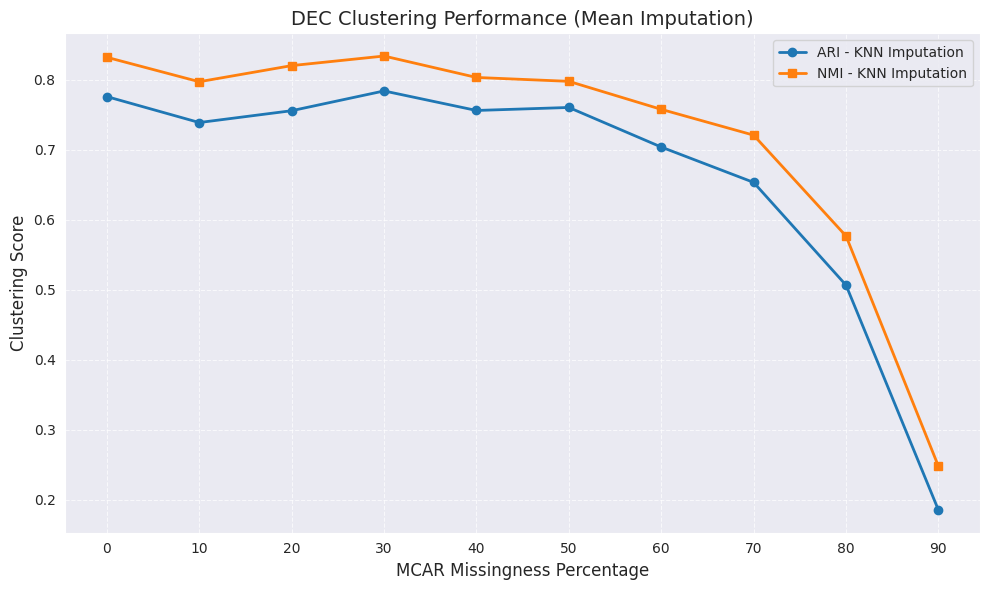

In [23]:
score_arrays = [ari_scores, nmi_scores]
labels = ['ARI - KNN Imputation', 'NMI - KNN Imputation']

plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=score_arrays,
    labels=labels,
    title='DEC Clustering Performance (Mean Imputation)'
)